## Default import and settings

In [2]:
import numpy as np
import pandas as pd
import re
from os.path import join

from tools import *

from sklearn.decomposition import LatentDirichletAllocation
from scipy.spatial import distance

import matplotlib.pyplot as plt
import numpy as np

## rename EXTRACT_FEATURES to DIMENSION_REDUCTION
read_prefix = "/data/MIMIC3/"
write_prefix = "/data/liu/LDA"
res_prefix = "/data/liu/LDA/lda_result"
res_r_prefix = "/data/liu/LDA/lda_R_result/"

In [13]:
diag_matrix_full = read_data(join(write_prefix, "diag_matrix"))
pres_matrix_full = read_data(join(write_prefix, "pres_matrix"))

In [3]:
diag_matrix = read_data(join(write_prefix, "diag_matrix_filtered"))
pres_matrix = read_data(join(write_prefix,"pres_matrix_filtered"))

In [9]:
del diag_matrix_full, pres_matrix_full

## Run LDA Models

In [ ]:
### Option: Get top columns of original matrix, only run for one time
## Sparsity metric for matrixes
def get_sparsity(matrix):
    sparsity = 1.0 - np.count_nonzero(matrix) / matrix.size
    return sparsity
## Sparsity metric for columns
def col_sparse(matrix):
    width = matrix.shape[1]-1
    sparse_list = []
    for col in range(0,width):
        sparse_list = sparse_list + [get_sparsity(matrix.iloc[:,col])]
    return sparse_list


## Calculating sparsity
# print("Sparsity of diagnosis matrix: %f"%get_sparsity(diag_matrix))
# print("Sparsity of prescriptions matrix: %f"%get_sparsity(pres_matrix))
diag_sparse = col_sparse(diag_matrix)
pres_sparse = col_sparse(pres_matrix)

## Only run for the first time for geting top N NDCs in SIDER4
# top10_NDC_ade = ade_df.groupby('NDC')['ICD9_CODE'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
# top10_NDCs = top10_NDC_ade['NDC']
# write2file(top10_NDC_ade,join(write_prefix,'top10_NDC_ade'))


## Get top NDC, top columns should include these NDCs regardless of their frequency
top10_NDC_ade = read_data(join(write_prefix,'top10_NDC_ade'),dtype={'NDC':str})
top10_NDCs = top10_NDC_ade['NDC']
    
    
top10_NDC_indexes = get_top_index(pres_matrix,top10_NDCs)
top10_NDC_indexes

## LDA on matrix with topN denser columns

## Only get columns which are top N least sparse
top_per = 0.2
def df_top_col(matrix, sparse_list, remain,top_per=0.2):
    m_len = len(sparse_list)
    top_N = int(m_len*top_per)
    filter_list = sorted(range(m_len), key=lambda i: sparse_list[i])[:top_N]
    final_list = list(set(filter_list).union(set(remain)))
    return matrix.iloc[:, final_list]

pres_matrix_filtered = df_top_col(pres_matrix,pres_sparse,top10_NDC_indexes)
diag_matrix_filtered = df_top_col(diag_matrix,diag_sparse,[])

In [ ]:
### Option: Write matrix to file
# write2file(pres_matrix_filtered,join(write_prefix,"pres_matrix_filtered"))
# write2file(diag_matrix_filtered,join(write_prefix,"diag_matrix_filtered"))

# write2file(pd.DataFrame({"SUBJECT_ID":pres_patient}),join(write_prefix,"pres_patient"))
# write2file(pd.DataFrame({"SUBJECT_ID":diag_patient}),join(write_prefix,"diag_patient"))

# write2file(diag_matrix,join(write_prefix,"diag_matrix"))
# write2file(pres_matrix,join(write_prefix,"pres_matrix"))

In [5]:
## RUM!->sklearn LDA on matrix with topN denser columns
## LDA analysis


def run_lda(pres_matrix, diag_matrix, pres_n_comp=5,diag_n_comp=5):
    lda = LatentDirichletAllocation(n_components=pres_n_comp, random_state=2019)
    pres_Z = lda.fit_transform(pres_matrix) 
    pres_Y = lda.components_


    lda_2 = LatentDirichletAllocation(n_components=diag_n_comp, random_state=2019)
#                                      ,doc_topic_prior=0.001,topic_word_prior=0.00001)
    diag_Z = lda_2.fit_transform(diag_matrix) 
    diag_Y = lda_2.components_
    
    return pres_Z, pres_Y, diag_Z, diag_Y

In [22]:
pres_n_comp=5
diag_n_comp=5
pres_Z, pres_Y, diag_Z, diag_Y = run_lda(pres_matrix, diag_matrix,pres_n_comp,diag_n_comp)

In [4]:
## Reading R LDA results
pres_n_comp=10
diag_n_comp=10

prefix = 'ngib700_ncomp10_gama0.01_alpha0.01'

# Default number of clusters for R results: 10
pres_Z = read_data(join(res_r_prefix,prefix,"presFull_theta"))
pres_Z = pres_Z.values

pres_Y = read_data(join(res_r_prefix,prefix,"presFull_phi"))
pres_Y = pres_Y.values

diag_Y = read_data(join(res_r_prefix,prefix,"diagFull_phi"))
diag_Y = diag_Y.values

diag_Z = read_data(join(res_r_prefix,prefix,"diagFull_theta"))
diag_Z = diag_Z.values

In [4]:
## Reading R LDA results
pres_n_comp=10
diag_n_comp=10

prefix = 'ngib700_ncomp10'

# Default number of clusters for R results: 10
pres_Z = read_data(join(res_r_prefix,prefix,"pres_theta"))
pres_Z = pres_Z.values

pres_Y = read_data(join(res_r_prefix,prefix,"pres_phi"))
pres_Y = pres_Y.values

diag_Y = read_data(join(res_r_prefix,prefix,"diag_phi"))
diag_Y = diag_Y.values

diag_Z = read_data(join(res_r_prefix,prefix,"diag_theta"))
diag_Z = diag_Z.values

## Result Analysis

In [5]:
## Get top index
def get_top_index(matrix, col_value):
    all_NDCs = matrix.columns
    all_NDC_map = {}
    for i in range(len(all_NDCs)):
        all_NDC_map[all_NDCs[i]]=i
        
    return [all_NDC_map[ndc] for ndc in col_value]

In [6]:
def sum_presPhi(pres_Y, top10_NDC_indexes, R=10, pres_n_comp=5, n_digits=4):
    
    columns = ["drug_%d"%(r) for r in list(range(R))]
    index = ["pres_c_%d"%(n) for n in list(range(pres_n_comp))]
    presY_top_sum = pd.DataFrame(pres_Y[:,top10_NDC_indexes],index=index, columns=columns).round(n_digits)
    presY_top_sum['sum'] = np.sum(presY_top_sum,axis=1).round(n_digits)
    presY_top_sum['std'] = np.std(presY_top_sum.iloc[:,:-1],axis=1).round(n_digits)
    presY_top_sum['drug_set'] = [(',').join(["drug_%d"%i for i in np.argwhere(ll>np.mean(ll)).flatten()]) 
                                 for ll in pres_Y[:,top10_NDC_indexes]]
    return presY_top_sum
    

In [7]:
def sum_diagPhi(diag_Y, diag_n_comp=5, n_digits=4):
    index = ["diag_c_%d"%(n) for n in list(range(diag_n_comp))]
    
    diag_Y_sum = pd.DataFrame(diag_Y,index=index).round(n_digits)
    diag_Y_sum['sum'] = np.sum(diag_Y,axis=1).round(n_digits)
    diag_Y_sum['std'] = np.std(diag_Y,axis=1).round(n_digits)
    return diag_Y_sum

In [9]:
## Get top NDC, top columns should include these NDCs regardless of their frequency
top10_NDC_ade = read_data(join(write_prefix,'top10_NDC_ade'),dtype={'NDC':str})
top10_NDCs = top10_NDC_ade['NDC']
top10_NDC_indexes = get_top_index(pres_matrix, top10_NDCs)
# top10_NDC_indexes = get_top_index(pres_matrix_full, top10_NDCs)

presPhi = sum_presPhi(pres_Y, top10_NDC_indexes,pres_n_comp=pres_n_comp,n_digits=10)
presPhi.iloc[:,1:]

,drug_1,drug_2,drug_3,drug_4,drug_5,drug_6,drug_7,drug_8,drug_9,sum,std,drug_set
pres_c_0,0.000265,0.000042,8.253950e-05,0.000381,4.910000e-07,0.000001,0.002165,0.000001,0.001246,0.004728,0.000673,"drug_0,drug_7,drug_9"
pres_c_1,0.003056,0.000369,2.302886e-04,0.005392,1.672900e-06,0.000233,0.000202,0.000444,0.007653,0.018344,0.002537,"drug_1,drug_4,drug_9"
pres_c_2,0.000002,0.000004,9.023310e-05,0.000002,1.758400e-06,0.000062,0.082551,0.000002,0.000084,0.082870,0.024755,drug_7
pres_c_3,0.002245,0.000004,8.975000e-07,0.080853,1.528600e-06,0.000002,0.000002,0.000003,0.000006,0.084933,0.024133,drug_4
pres_c_4,0.007936,0.000005,4.910400e-06,0.000057,3.446600e-06,0.000004,0.000006,0.000007,0.000004,0.010433,0.002406,"drug_0,drug_1"
pres_c_5,0.000013,0.000018,4.042641e-02,0.066861,2.874541e-03,0.000139,0.000008,0.000015,0.021529,0.131994,0.021987,"drug_3,drug_4,drug_9"
pres_c_6,0.000055,0.000019,5.255896e-04,0.000008,1.544230e-05,0.000017,0.000375,0.001397,0.000172,0.002603,0.000415,"drug_3,drug_7,drug_8"
pres_c_7,0.000018,0.000046,4.082700e-06,0.000006,5.549500e-06,0.000008,0.000004,0.000011,0.000044,0.000166,0.000015,"drug_0,drug_1,drug_2,drug_9"
pres_c_8,0.000960,0.000011,1.516660e-05,0.000012,1.258390e-05,0.000008,0.000002,0.000130,0.000007,0.001166,0.000283,"drug_1,drug_8"
pres_c_9,0.000300,0.000169,2.698466e-04,0.401655,2.266862e-04,0.000239,0.000250,0.000176,0.000997,0.405178,0.120379,drug_4


In [10]:
diagPhi = sum_diagPhi(diag_Y,diag_n_comp=diag_n_comp)
diagPhi.iloc[:,-13:]

,1298,1299,1300,1301,1302,1303,1304,1305,1306,1307,1308,sum,std
diag_c_0,0.0243,0.0126,0.0005,0.0052,0.0053,0.0288,0.0010,0.0004,0.0042,0.0100,0.0000,5.9304,0.0143
diag_c_1,0.0002,0.0008,0.0028,0.0144,0.0177,0.0346,0.0042,0.0097,0.0188,0.0097,0.0093,11.3142,0.0297
diag_c_2,0.0023,0.0031,0.0043,0.0040,0.0000,0.0364,0.0000,0.0000,0.0009,0.0014,0.0071,5.0296,0.0103
diag_c_3,0.0000,0.0002,0.0106,0.0419,0.0162,0.0236,0.0001,0.0284,0.0056,0.0012,0.0174,35.5038,0.0690
diag_c_4,0.0001,0.0000,0.0003,0.0016,0.0001,0.0861,0.0118,0.0000,0.0188,0.0190,0.0001,3.4525,0.0151
diag_c_5,0.0001,0.0001,0.0027,0.0088,0.0029,0.0032,0.0001,0.0003,0.0014,0.0002,0.0000,24.7265,0.0750
diag_c_6,0.0087,0.0592,0.0030,0.0000,0.0124,0.0248,0.0000,0.0001,0.0000,0.0097,0.0022,5.1355,0.0195
diag_c_7,0.3159,0.0077,0.0057,0.0001,0.0001,0.0087,0.0002,0.0005,0.0001,0.0001,0.0001,8.8153,0.0457
diag_c_8,0.8817,0.7046,0.0001,0.0004,0.0007,0.0010,0.0000,0.0001,0.0001,0.0001,0.0010,28.2188,0.1136
diag_c_9,0.3060,0.3218,0.3167,0.2765,0.3132,0.2987,0.3123,0.2933,0.3060,0.3001,0.3161,409.1461,0.0329


In [53]:
# write2file(presY_top_ndc,join(write_prefix,"lda_result/c5_presY_top_ndc"))

In [20]:
# write2file(diagY_df,join(write_prefix,"lda_result/c5_diagY_df"))

In [11]:
def sum_dis(dis_df):
    dis_df['min'] = dis_df.min(axis=1)
    dis_df['argmin']=dis_df.iloc[:,:-1].idxmin(axis=1)
    dis_df['std']= dis_df.iloc[:,:-2].std(axis=1)
    return dis_df
#     current_result = l +[current_range,np.argmin(l),np.min(l)]
#     print("Distance between pres_%d and diag_j(j∈[0,%d): %s"%(i,n_comp,l))
#     print("Min:%f  Range:%f arg_min:%d"%(np.min(l),current_range,np.argmin(l)))

def get_ditance(pres_Z, diag_Z, pres_n_comp =5,diag_n_comp=5):    

    dis_list = []
    for i in range(pres_n_comp):
        l = []
        for j in range(diag_n_comp):
            sim_i_j = distance.euclidean(pres_Z[:,i],diag_Z[:,j])
            l = l + [sim_i_j]
        for j in range(diag_n_comp):
            sim_i_j = distance.cosine(pres_Z[:,i],diag_Z[:,j])
            l = l + [sim_i_j]
        for j in range(diag_n_comp):
            sim_i_j = distance.correlation(pres_Z[:,i],diag_Z[:,j])
            l = l + [sim_i_j]            
        dis_list = dis_list + l
        
    dis_array = np.reshape(dis_list, [pres_n_comp,-1])
    dis_3array =np.array_split(dis_array,3,axis=1)
    columns = ["diag_c_%d"%(n) for n in list(range(diag_n_comp))]
    index = ["pres_c_%d"%(n) for n in list(range(pres_n_comp))]
    
    dis_3df = [sum_dis(pd.DataFrame(array,columns=columns,index=index)) for array in dis_3array]

    return dis_3df

In [12]:
dis_3df = get_ditance(pres_Z,diag_Z,pres_n_comp=pres_n_comp,diag_n_comp=diag_n_comp)

In [13]:
dis_length = min([13, len(dis_3df[0].columns)])
dis_3df[0].iloc[:,-dis_length:]

,diag_c_0,diag_c_1,diag_c_2,diag_c_3,diag_c_4,diag_c_5,diag_c_6,diag_c_7,diag_c_8,diag_c_9,min,argmin,std
pres_c_0,56.854044,59.122403,57.496514,67.586678,69.060563,73.437974,74.890543,75.880846,76.523998,77.140397,56.854044,diag_c_0,8.189674
pres_c_1,69.955883,53.222139,53.917214,51.584954,58.554213,60.490153,62.705071,63.660013,64.359591,64.366010,51.584954,diag_c_3,5.899072
pres_c_2,59.388154,60.220164,46.892237,46.486250,42.736563,44.602963,44.377067,44.867212,44.401271,46.473477,42.736563,diag_c_4,6.324432
pres_c_3,70.582913,56.506254,44.339126,38.055764,36.834213,37.062791,37.305422,38.023357,38.700751,38.452288,36.834213,diag_c_4,11.233210
pres_c_4,73.357035,59.916633,46.143718,39.592038,32.257619,30.882949,30.596904,30.873647,31.413323,31.039296,30.596904,diag_c_6,14.953209
pres_c_5,75.134979,58.734556,43.699926,24.707938,27.058123,23.537938,23.479202,23.781034,24.306474,23.779316,23.479202,diag_c_6,18.405149
pres_c_6,75.510041,59.739269,42.877240,29.281059,19.589804,13.367784,11.678922,11.331014,11.996372,10.825816,10.825816,diag_c_9,23.247108
pres_c_7,76.395132,61.338214,47.075890,37.120482,29.151627,25.513142,25.311146,25.309639,25.676637,25.139024,25.139024,diag_c_9,18.181656
pres_c_8,76.969200,60.952174,46.663658,34.976417,27.256810,22.481336,22.478961,22.371869,22.745331,22.122477,22.122477,diag_c_9,19.470106
pres_c_9,77.761853,62.655907,44.489111,29.919296,19.179991,11.612902,7.002287,5.557896,6.385422,3.380784,3.380784,diag_c_9,26.462750


In [14]:
dis_3df[1].iloc[:,-dis_length:]

,diag_c_0,diag_c_1,diag_c_2,diag_c_3,diag_c_4,diag_c_5,diag_c_6,diag_c_7,diag_c_8,diag_c_9,min,argmin,std
pres_c_0,0.365723,0.386163,0.399792,0.394471,0.391405,0.424971,0.446934,0.507669,0.556338,0.650453,0.365723,diag_c_0,0.091657
pres_c_1,0.462757,0.420750,0.418425,0.447375,0.477187,0.477046,0.552621,0.517874,0.632061,0.705879,0.418425,diag_c_2,0.094163
pres_c_2,0.383633,0.417949,0.427590,0.420751,0.412344,0.454690,0.431048,0.530582,0.562867,0.661980,0.383633,diag_c_0,0.087317
pres_c_3,0.401264,0.421856,0.430670,0.422565,0.423585,0.455324,0.457851,0.537674,0.572391,0.668060,0.401264,diag_c_0,0.086162
pres_c_4,0.552234,0.562909,0.567533,0.573189,0.571802,0.581185,0.614660,0.647168,0.685859,0.743718,0.552234,diag_c_0,0.063281
pres_c_5,0.531111,0.488850,0.484557,0.503524,0.542809,0.538351,0.602784,0.575244,0.688333,0.739071,0.484557,diag_c_2,0.085144
pres_c_6,0.513712,0.545737,0.552533,0.547872,0.540137,0.577794,0.555035,0.637598,0.657859,0.736183,0.513712,diag_c_0,0.069064
pres_c_7,0.626509,0.617777,0.606686,0.624820,0.640455,0.639820,0.691031,0.676747,0.745007,0.787284,0.606686,diag_c_2,0.059749
pres_c_8,0.723027,0.709130,0.698074,0.730264,0.740830,0.730406,0.775877,0.768663,0.814347,0.844113,0.698074,diag_c_2,0.046960
pres_c_9,0.721606,0.718810,0.724243,0.729163,0.733748,0.741238,0.759403,0.778576,0.804923,0.840609,0.718810,diag_c_1,0.040927


In [15]:
dis_3df[2].iloc[:,-dis_length:]

,diag_c_0,diag_c_1,diag_c_2,diag_c_3,diag_c_4,diag_c_5,diag_c_6,diag_c_7,diag_c_8,diag_c_9,min,argmin,std
pres_c_0,0.969751,1.016911,1.040956,1.004732,0.974364,1.004805,0.979358,1.024418,0.981180,0.992081,0.969751,diag_c_0,0.023587
pres_c_1,1.053194,0.950900,0.937328,0.985939,1.033418,0.991799,1.081882,0.946694,1.038064,1.025759,0.937328,diag_c_2,0.049448
pres_c_2,0.959650,1.039172,1.052228,1.014752,0.973959,1.024403,0.904832,1.032390,0.965235,0.990819,0.904832,diag_c_6,0.045460
pres_c_3,0.981285,1.025649,1.036744,0.997625,0.980131,1.006545,0.945882,1.031117,0.971602,0.992683,0.945882,diag_c_6,0.028798
pres_c_4,0.990367,1.007691,1.010608,1.009581,0.994857,0.984895,1.002282,1.008552,0.991958,0.985415,0.984895,diag_c_5,0.010261
pres_c_5,1.052598,0.960173,0.944759,0.970416,1.034215,0.992562,1.060484,0.958200,1.049981,1.018309,0.944759,diag_c_2,0.044185
pres_c_6,0.965639,1.026432,1.033187,1.010833,0.982796,1.023015,0.939647,1.027951,0.977493,0.994850,0.939647,diag_c_6,0.031354
pres_c_7,1.015202,0.995974,0.970870,0.994589,1.012392,0.988916,1.038302,0.978452,1.014947,0.998444,0.970870,diag_c_2,0.019867
pres_c_8,1.010725,0.984464,0.962283,1.010646,1.021033,0.988497,1.034155,0.996784,1.014893,1.001190,0.962283,diag_c_2,0.020565
pres_c_9,1.000725,0.993852,0.999913,1.001746,1.002578,0.999270,1.004211,1.005736,0.998959,0.994190,0.993852,diag_c_1,0.003857


In [18]:
# presZ_diagZ_c5_distance = pd.DataFrame(np.reshape(all_result,[5,-1])).round(4)
# presZ_diagZ_c5_distance

In [70]:
# presZ_diagZ_c5_distance.columns = list(presZ_diagZ_c5_distance.columns[:5]) + ['range','argmin','min']
# presZ_diagZ_c5_distance

In [17]:
## RUN! Validation process
def get_predict_top_diag(diag_Y, feature_index,topN):
    current_feature = diag_Y[feature_index]
    mean = np.mean(current_feature)
    top_diag_indices = current_feature.argsort()[-topN:][::-1]
    
#     if(len(current_feature)>topN):
#         top_diag_indices = current_feature.argsort()[-topN:][::-1]
#     else:
#         top_diag_indices = current_feature.argsort()[::-1]
    select_ICD9s = [all_ICD9s[i] for i in top_diag_indices]
    return select_ICD9s

# def get_true_diag(ade_df, presPhi,ndc_list):
    
#     num_item = len(ndc_list)
#     index_l = []
#     l = []
#     for index, row in presPhi.iterrows():
#     #     print(np.percentile(row[:10], 75))
#         indexes = np.argwhere(row[:10]>(row['sum']/num_item)).flatten()
#         index_l = index_l+[["drug_%d"%ii for ii in indexes]]
#         l=l+[[ndc_list[i] for i in indexes]]

#     return index_l,[ade_df[ade_df['NDC'].isin(ndcs)]['ICD9_CODE'].unique() for ndcs in l]

# def get_true_diag(ade_df, presPhi,ndc_list, R=10):
    
#     index_l = []
#     l = []
#     for index, row in presPhi.iterrows():
#     #     print(np.percentile(row[:10], 75))
#         indexes = np.argwhere(row[:R]>(row['sum']/R)).flatten()
#         index_l = index_l+[["drug_%d"%ii for ii in indexes]]
#         l=l+[[ndc_list[i] for i in indexes]]

#     return index_l,[ade_df[ade_df['NDC'].isin(ndcs)]['ICD9_CODE'].unique() for ndcs in l]


def get_validation(diag_Y, presPhi, dis, ade_df, ndc_list, pres_n_comp, n_top_disease, union=False,print_set=False):
    l = []
#     actual_ICD9s_len = len(actual_ICD9s)

    drug_set = presPhi['drug_set']
    drug_index_l = [[int(re.sub("[^0-9]", "",s)) for s in ss.split(',')] 
                    for ss in drug_set]

#     true_ade_group = [ade_df[ade_df['NDC'].isin(ndc_list[pres_drugs])]['ICD9_CODE'].unique() for pres_drugs in drug_index_l]

#     ndc_group, true_ade_group = get_true_diag(ade_df, presPhi, ndc_list)
    pre_min_diag = dis['argmin']
    pre_min_diag_int = [int(re.sub("[^0-9]", "",s)) for s in pre_min_diag]
    
    len_true_ade = []
    for i in range(pres_n_comp):
    #     print(len(set(get_top_diag(i)[:100])-set(actual_ICD9s)))
        predict_disease = get_predict_top_diag(diag_Y,pre_min_diag_int[i],n_top_disease)
        selected_ades = ade_df[ade_df['NDC'].isin(ndc_list[drug_index_l[i]])]            
        if(union==False):
            #intersection of each drug in a drug set
            actual_ICD9s = set.intersection(*[set(df['ICD9_CODE']) for _,df in selected_ades.groupby('NDC')])
        else: 
            actual_ICD9s = set.union(*[set(df['ICD9_CODE']) for _,df in selected_ades.groupby('NDC')])


#         actual_ICD9s = ade_df[ade_df['NDC'].isin([ndc_list[inx] for inx in drug_index_l[i]])]['ICD9_CODE'].unique()
        len_true_ade=len_true_ade+[len(actual_ICD9s)]
        matched_disease = set(predict_disease).intersection(set(actual_ICD9s))
        precision = len(matched_disease)/len(predict_disease)*100
        if(len(actual_ICD9s)>0):
            recall = (len(matched_disease)/len(actual_ICD9s)*100)
        else: recall=0
            
        l = l +[precision, recall]
        if(print_set): 
            print("pres_%d:"%i)
            print(matched_disease)
    
    valid_df = pd.DataFrame(np.reshape(l,[pres_n_comp,-1]),
                            index=["pres_c_%d"% i for i in list(range(pres_n_comp))],
                            columns=["precision%","recall%"]).round(2)

    valid_df.insert(loc=0, column='closest_diag_c', value=pre_min_diag)
    valid_df.insert(loc=1, column='drug_set', value=drug_set)
    valid_df.insert(loc=2, column='len(true_ade)', value=len_true_ade)
    return valid_df


In [15]:
## RUN! combine validation
sideffect_prefix = '/data/liu/adverse_events'
ade_df = read_data(join(sideffect_prefix, 'ndc_icd9_side_effects'), dtype={'NDC':str},usecols=['NDC','ICD9_CODE'])

# all_ICD9s = diag_matrix.columns
all_ICD9s = diag_matrix.columns
# all_ICD9s = diag_matrix_full.columns

#real_diseases  = ade_df[ade_df['NDC'].isin(top10_NDCs)]
#actual_ICD9s = real_diseases['ICD9_CODE'].unique()

def get_validation_combine(diag_Y, presPhi, distance, ade_df, top10_NDCs, pres_n_comp, topn,union=False):
    dfs = [get_validation(diag_Y, presPhi, distance, ade_df, top10_NDCs, pres_n_comp, n,union=union) for n in topn]
    index = list(dfs[0].columns[:3])
    
    raw_index = dfs[0].index
    dfs_index = pd.concat([df.set_index(index) for df in dfs],axis=1).reset_index()
    dfs_index.index = raw_index
    return dfs_index

/home/liu/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [18]:
dis = dis_3df[0]
get_validation_combine(diag_Y, presPhi, dis, ade_df, top10_NDCs, pres_n_comp, [30, 100, 1000])

,closest_diag_c,drug_set,len(true_ade),precision%,recall%,precision%,recall%,precision%,recall%
pres_c_0,diag_c_0,"drug_0,drug_7,drug_9",252,23.33,2.78,14.0,5.56,7.6,30.16
pres_c_1,diag_c_3,"drug_1,drug_4,drug_9",253,33.33,3.95,20.0,7.91,8.6,33.99
pres_c_2,diag_c_4,drug_7,512,23.33,1.37,20.0,3.91,15.3,29.88
pres_c_3,diag_c_4,drug_4,513,23.33,1.36,20.0,3.90,15.4,30.02
pres_c_4,diag_c_6,"drug_0,drug_1",623,33.33,1.61,33.0,5.30,19.5,31.30
pres_c_5,diag_c_6,"drug_3,drug_4,drug_9",268,26.67,2.99,20.0,7.46,8.5,31.72
pres_c_6,diag_c_9,"drug_3,drug_7,drug_8",267,16.67,1.87,13.0,4.87,7.8,29.21
pres_c_7,diag_c_9,"drug_0,drug_1,drug_2,drug_9",247,16.67,2.02,12.0,4.86,6.9,27.94
pres_c_8,diag_c_9,"drug_1,drug_8",282,16.67,1.77,13.0,4.61,8.1,28.72
pres_c_9,diag_c_9,drug_4,513,30.00,1.75,25.0,4.87,13.9,27.10


In [23]:
# dis = dis_3df[0]
# get_validation_combine(diag_Y, presPhi, dis, ade_df, top10_NDCs, pres_n_comp, [30, 100, 1000])
# aa = get_validation(diag_Y, presPhi, distance, ade_df, top10_NDCs, pres_n_comp, 30)
# aa.index

In [24]:
dis = dis_3df[1]
get_validation_combine(diag_Y, presPhi, dis, ade_df, top10_NDCs, pres_n_comp, [30, 100, 1000])
# aa = get_validation(diag_Y, presPhi, distance, ade_df, top10_NDCs, pres_n_comp, 30)
# aa.index

,closest_diag_c,drug_set,len(true_ade),precision%,recall%,precision%,recall%,precision%,recall%
pres_c_0,diag_c_0,"drug_0,drug_7",420,26.67,1.90,21.0,5.00,11.7,27.86
pres_c_1,diag_c_2,"drug_3,drug_4,drug_9",268,30.00,3.36,17.0,6.34,7.3,27.24
pres_c_2,diag_c_0,drug_7,512,33.33,1.95,26.0,5.08,13.7,26.76
pres_c_3,diag_c_0,"drug_1,drug_7",420,26.67,1.90,21.0,5.00,11.7,27.86
pres_c_4,diag_c_0,"drug_1,drug_4",421,26.67,1.90,21.0,4.99,11.8,28.03
pres_c_5,diag_c_2,"drug_3,drug_4,drug_9",268,30.00,3.36,17.0,6.34,7.3,27.24
pres_c_6,diag_c_0,drug_7,512,33.33,1.95,26.0,5.08,13.7,26.76
pres_c_7,diag_c_2,drug_4,513,40.00,2.34,30.0,5.85,14.7,28.65
pres_c_8,diag_c_2,"drug_3,drug_4,drug_8",268,30.00,3.36,17.0,6.34,7.3,27.24
pres_c_9,diag_c_1,"drug_1,drug_2,drug_4",327,33.33,3.06,26.0,7.95,9.1,27.83


In [18]:
dis = dis_3df[1]
get_validation_combine(diag_Y, presPhi, dis, ade_df, top10_NDCs, pres_n_comp, [30, 100, 1000],union=True)


,closest_diag_c,drug_set,len(true_ade),precision%,recall%,precision%,recall%,precision%,recall%
pres_c_0,diag_c_1,"drug_0,drug_9",675,36.67,1.63,29.0,4.30,19.6,29.04
pres_c_1,diag_c_0,drug_1,623,46.67,2.25,42.0,6.74,17.6,28.25
pres_c_2,diag_c_4,drug_7,512,3.33,0.20,10.0,1.95,15.3,29.88
pres_c_3,diag_c_0,drug_4,513,43.33,2.53,35.0,6.82,14.5,28.27
pres_c_4,diag_c_0,"drug_1,drug_4",715,53.33,2.24,46.0,6.43,19.8,27.69
pres_c_5,diag_c_3,"drug_3,drug_4,drug_9",579,40.00,2.07,39.0,6.74,16.2,27.98
pres_c_6,diag_c_1,"drug_3,drug_8",579,36.67,1.90,27.0,4.66,16.0,27.63
pres_c_7,diag_c_2,"drug_4,drug_5",680,40.00,1.76,35.0,5.15,19.5,28.68
pres_c_8,diag_c_2,drug_0,623,33.33,1.61,32.0,5.14,18.2,29.21
pres_c_9,diag_c_2,drug_4,513,36.67,2.14,27.0,5.26,14.9,29.04


In [25]:
dis = dis_3df[2]
get_validation_combine(diag_Y, presPhi, dis, ade_df, top10_NDCs, pres_n_comp, [30, 100, 1000])
# aa = get_validation(diag_Y, presPhi, distance, ade_df, top10_NDCs, pres_n_comp, 30)
# aa.index

,closest_diag_c,drug_set,len(true_ade),precision%,recall%,precision%,recall%,precision%,recall%
pres_c_0,diag_c_0,"drug_0,drug_7",420,26.67,1.90,21.0,5.00,11.7,27.86
pres_c_1,diag_c_2,"drug_3,drug_4,drug_9",268,30.00,3.36,17.0,6.34,7.3,27.24
pres_c_2,diag_c_6,drug_7,512,20.00,1.17,21.0,4.10,12.4,24.22
pres_c_3,diag_c_6,"drug_1,drug_7",420,16.67,1.19,18.0,4.29,10.2,24.29
pres_c_4,diag_c_5,"drug_1,drug_4",421,26.67,1.90,20.0,4.75,10.4,24.70
pres_c_5,diag_c_2,"drug_3,drug_4,drug_9",268,30.00,3.36,17.0,6.34,7.3,27.24
pres_c_6,diag_c_6,drug_7,512,20.00,1.17,21.0,4.10,12.4,24.22
pres_c_7,diag_c_2,drug_4,513,40.00,2.34,30.0,5.85,14.7,28.65
pres_c_8,diag_c_2,"drug_3,drug_4,drug_8",268,30.00,3.36,17.0,6.34,7.3,27.24
pres_c_9,diag_c_1,"drug_1,drug_2,drug_4",327,33.33,3.06,26.0,7.95,9.1,27.83


In [21]:
dis = dis_3df[2]
get_validation_combine(diag_Y, presPhi, dis, ade_df, top10_NDCs, pres_n_comp, [30, 100, 1000],union=True)


,closest_diag_c,drug_set,len(true_ade),precision%,recall%,precision%,recall%,precision%,recall%
pres_c_0,diag_c_4,"drug_0,drug_9",675,0.00,0.00,13.0,1.93,19.8,29.33
pres_c_1,diag_c_5,drug_1,623,36.67,1.77,34.0,5.46,18.9,30.34
pres_c_2,diag_c_4,drug_7,512,3.33,0.20,10.0,1.95,15.3,29.88
pres_c_3,diag_c_3,drug_4,513,33.33,1.95,33.0,6.43,14.8,28.85
pres_c_4,diag_c_0,"drug_1,drug_4",715,53.33,2.24,46.0,6.43,19.8,27.69
pres_c_5,diag_c_3,"drug_3,drug_4,drug_9",579,40.00,2.07,39.0,6.74,16.2,27.98
pres_c_6,diag_c_5,"drug_3,drug_8",579,30.00,1.55,32.0,5.53,16.5,28.50
pres_c_7,diag_c_2,"drug_4,drug_5",680,40.00,1.76,35.0,5.15,19.5,28.68
pres_c_8,diag_c_5,drug_0,623,36.67,1.77,34.0,5.46,18.9,30.34
pres_c_9,diag_c_2,drug_4,513,36.67,2.14,27.0,5.26,14.9,29.04


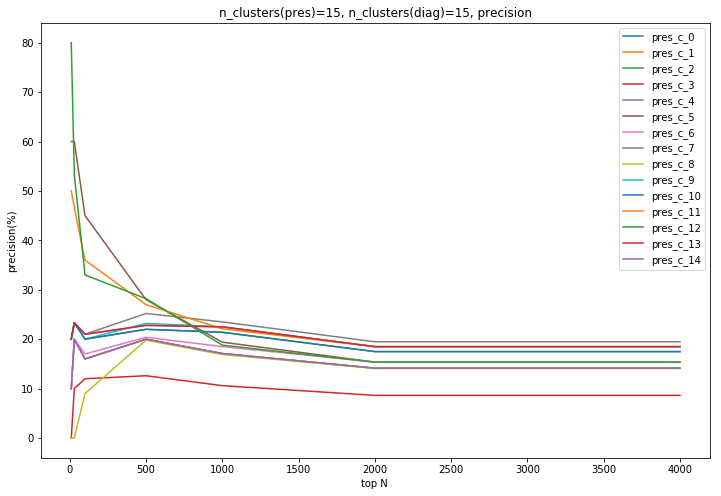

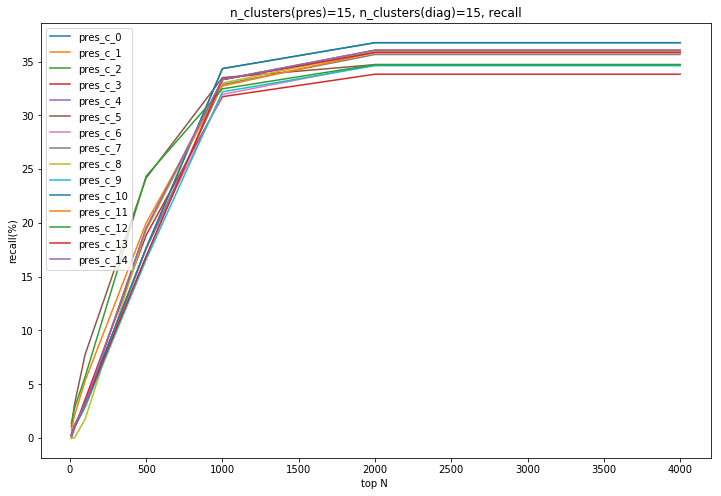

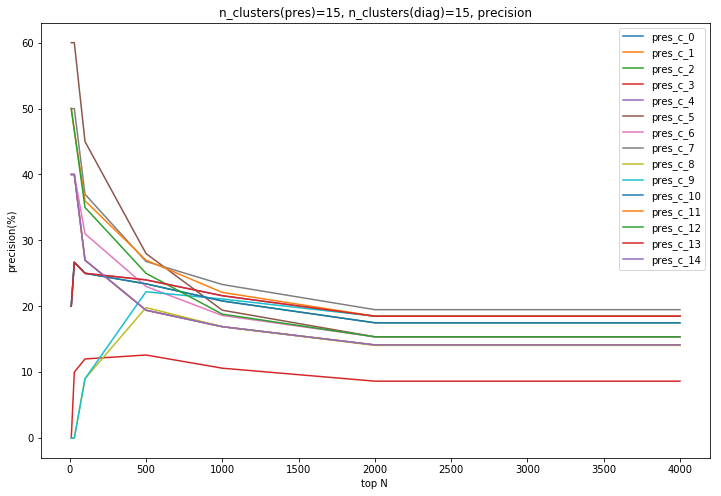

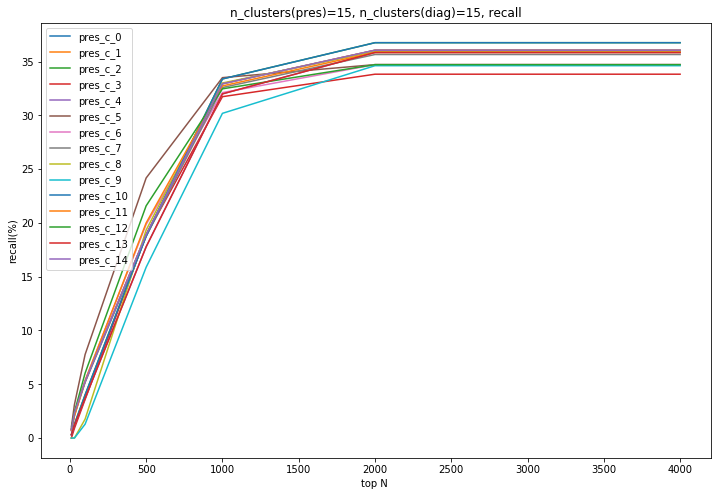

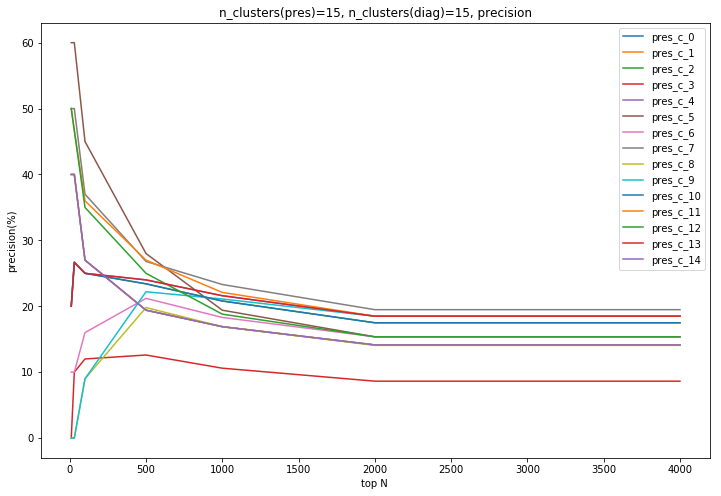

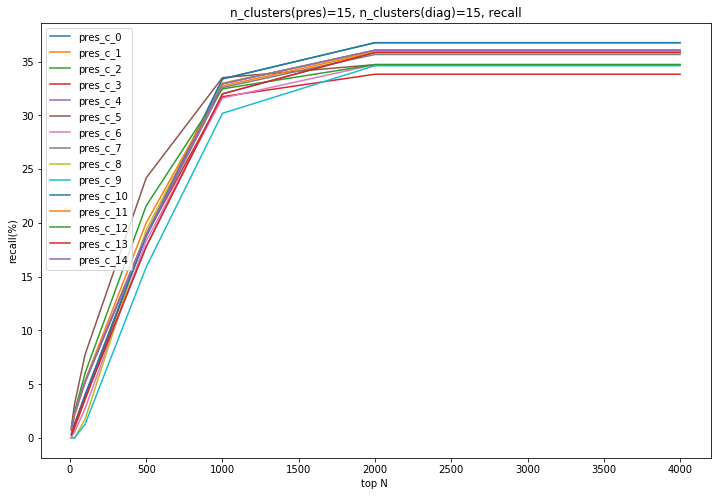

In [28]:
def plot_res(topn_set, metric, pres_n_comp=5, diag_n_comp =5, title = "precision", loc="upper left"):
    
    plt.figure(figsize=(12, 8))
    
    for i in range(pres_n_comp):
        plt.plot(topn_set, metric.iloc[i,:])

    plt.title("n_clusters(pres)=%d, n_clusters(diag)=%d, %s"%(pres_n_comp, diag_n_comp, title))
    plt.xlabel("top N ")
    plt.ylabel(title+"(%)")
    plt.legend(["pres_c_%d"%(n) for n in list(range(pres_n_comp))], loc=loc)

    plt.show()
    

for i in range(3):
    distance = dis_3df[i]
    topn_set = [10, 30, 100, 500, 1000,2000,3000, 4000]
    valid_set = [get_validation(diag_Y, presPhi, distance, ade_df, top10_NDCs, pres_n_comp, topn) for topn in topn_set]

    precision = pd.DataFrame(np.array([valid.iloc[:,-2] for valid in valid_set]).T, columns=topn_set)
    recall = pd.DataFrame(np.array([valid.iloc[:,-1] for valid in valid_set]).T, columns=topn_set)

    plot_res(topn_set, precision,pres_n_comp, diag_n_comp, title = "precision", loc="upper right")
    plot_res(topn_set, recall,pres_n_comp, diag_n_comp, title = "recall", loc="upper left")

## Validation

In [3]:
diag_Y_df = read_data(join(write_prefix,"lda_result/c5_diagY_df"))
diag_Y_df

,0,1,2,3,4,5,6,7,8,9,...,6538,6539,6540,6541,6542,6543,6544,6545,6546,sum
0,0.2000,0.2011,0.202,0.2000,3.1463,1.1999,1.1914,0.2000,0.2000,0.2,...,0.2345,0.2000,0.2019,1.1961,1.1972,1.1964,0.2000,0.2000,0.2000,273230.4214
1,0.2000,0.2000,0.200,0.2000,0.2001,0.2000,0.2000,2.0113,0.2022,0.2,...,0.2001,0.2000,0.2000,0.2000,0.2000,0.2000,0.2000,0.2000,1.1989,58145.2910
2,0.2000,0.2000,0.200,0.2000,0.2169,0.2000,0.2000,0.2000,0.2000,0.2,...,0.2011,0.2000,0.2000,0.2000,0.2000,0.2000,0.8453,3.1997,0.2002,108281.6506
3,0.2047,0.2000,2.197,0.2005,0.2000,0.2000,0.2000,0.2000,1.1965,0.2,...,113.7868,0.2024,0.2017,0.2000,0.2028,0.2000,0.2023,0.2003,0.2000,192245.4866
4,1.1953,1.1989,0.201,1.1994,0.2367,0.2000,0.2085,0.3887,0.2014,1.2,...,4.5776,1.1975,4.1963,0.2039,0.2000,0.2035,0.5524,0.2000,0.2009,278610.9550


In [4]:
diag_Y = diag_Y_df.iloc[:,:-1]
diag_Y
#diag_matrix = read_data(join(write_prefix, "diag_matrix"))

,0,1,2,3,4,5,6,7,8,9,...,6537,6538,6539,6540,6541,6542,6543,6544,6545,6546
0,0.2000,0.2011,0.202,0.2000,3.1463,1.1999,1.1914,0.2000,0.2000,0.2,...,1.1994,0.2345,0.2000,0.2019,1.1961,1.1972,1.1964,0.2000,0.2000,0.2000
1,0.2000,0.2000,0.200,0.2000,0.2001,0.2000,0.2000,2.0113,0.2022,0.2,...,0.2000,0.2001,0.2000,0.2000,0.2000,0.2000,0.2000,0.2000,0.2000,1.1989
2,0.2000,0.2000,0.200,0.2000,0.2169,0.2000,0.2000,0.2000,0.2000,0.2,...,0.2000,0.2011,0.2000,0.2000,0.2000,0.2000,0.2000,0.8453,3.1997,0.2002
3,0.2047,0.2000,2.197,0.2005,0.2000,0.2000,0.2000,0.2000,1.1965,0.2,...,0.2006,113.7868,0.2024,0.2017,0.2000,0.2028,0.2000,0.2023,0.2003,0.2000
4,1.1953,1.1989,0.201,1.1994,0.2367,0.2000,0.2085,0.3887,0.2014,1.2,...,0.2000,4.5776,1.1975,4.1963,0.2039,0.2000,0.2035,0.5524,0.2000,0.2009


In [5]:
sideffect_prefix = '/data/liu/adverse_events'
ade_df = read_data(join(sideffect_prefix, 'ndc_icd9_side_effects'), dtype={'NDC':str, 'ICD_CODE':str})
ade_df.head()

/home/liu/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


,NDC,drugbank_id,UMLS_CUI,ICD_CODE,SNOMED_CID,ICD9_CODE
0,00003029305,DB00620,C0000731,789.36,60728008,78936
1,00003049420,DB00620,C0000731,789.36,60728008,78936
2,00009001104,DB00620,C0000731,789.36,60728008,78936
3,00009001201,DB00620,C0000731,789.36,60728008,78936
4,00009003101,DB00620,C0000731,789.36,60728008,78936


In [6]:
top10_NDC_ade = read_data(join(write_prefix,'top10_NDC_ade'),dtype={'NDC':str})
top10_NDCs = top10_NDC_ade['NDC']
real_diseases  = ade_df[ade_df['NDC'].isin(top10_NDCs)]
real_diseases.head()

,NDC,drugbank_id,UMLS_CUI,ICD_CODE,SNOMED_CID,ICD9_CODE
38,24208063562,DB00620,C0000731,789.36,60728008,78936
87,24208063562,DB00741,C0000731,789.36,60728008,78936
208,00025152031,DB00188,C0000731,789.36,60728008,78936
209,00025152531,DB00188,C0000731,789.36,60728008,78936
211,00472011720,DB00188,C0000731,789.36,60728008,78936


In [7]:
# all_ICD9s = diag_matrix.columns
all_ICD9s = diag_matrix.columns
def get_top_diag(feature_index,topN=1000):
    top_diag_indices = diag_Y.iloc[feature_index,:].argsort()[-topN:][::-1]
    select_ICD9s = [all_ICD9s[i] for i in top_diag_indices]
    return select_ICD9s
# write2file(pd.DataFrame({'ICD9_CODE':select_ICD9s}),join(write_prefix,'top1000_icd9'))

In [8]:
# diag_Y.iloc[0,:]

In [9]:
actual_ICD9s = real_diseases['ICD9_CODE'].unique()
actual_ICD9s_len = len(actual_ICD9s)
len(actual_ICD9s)

800

In [12]:
n_comp = 5
def get_validation(n_comp, n_top_disease):
    l = []
    for i in range(n_comp):
    #     print(len(set(get_top_diag(i)[:100])-set(actual_ICD9s)))
        top_disease = get_top_diag(i)[:n_top_disease]
        matched_disease = set(top_disease).intersection(set(actual_ICD9s))
        precision = len(matched_disease)/30*100
        recall = (len(matched_disease)/actual_ICD9s_len*100)
        print("Diag_%d:"%i)
        print("Precision: %.2f%%"%precision)
        print("Recall: %.2f%%"%recall)
        l = l +[precision, recall]
        print(matched_disease)
    return l

In [27]:
validation_result = get_validation(5,30)
valid_res_df = pd.DataFrame(np.reshape(validation_result,[5,-1]),columns=["precision%","recall%"]).round(2)
valid_res_df

Diag_0:
Precision: 46.67%
Recall: 1.75%
{'42731', '2724', '5859', '4254', '496', '486', '2449', '4019', '41400', '5990', '5849', '53081', '4240', '2859'}
Diag_1:
Precision: 0.00%
Recall: 0.00%
set()
Diag_2:
Precision: 33.33%
Recall: 1.25%
{'7843', '4019', '78039', '5990', '431', '34290', '430', '43491', '3485', '311'}
Diag_3:
Precision: 43.33%
Recall: 1.62%
{'42731', '2724', '71590', '27800', '496', '2449', '4019', '42789', '73300', '53081', '2859', '4139', '311'}
Diag_4:
Precision: 56.67%
Recall: 2.12%
{'42731', '5180', '78959', '5119', '2875', '486', '0389', '4019', '7907', '5990', '5770', '5849', '78552', '99591', '2762', '2767', '2859'}


,precision%,recall%
0,46.67,1.75
1,0.00,0.00
2,33.33,1.25
3,43.33,1.62
4,56.67,2.12


In [28]:
write2file(valid_res_df,join(write_prefix,"lda_result/c5_validation"))

In [30]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread("/data/liu/LDA/r_plot.png")
imgplot = plt.imshow(img)
plt.show()

<Figure size 640x480 with 1 Axes>

In [31]:
plt.show()

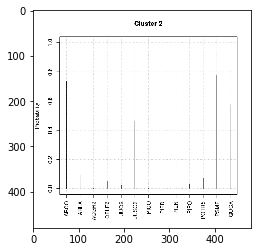

In [32]:
plt.figure()
plt.imshow(img) 
plt.show()